**Source : https://www.kaggle.com/shivan118/hranalysis**

# Importing Modules and Files

In [2]:
# Modules needed
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np, math, warnings, joblib
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, recall_score, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from IPython.core.display import display, HTML
from imblearn.over_sampling import SMOTE
from collections import Counter

display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings("ignore")

data = pd.read_csv("./fullprocesseddata.csv")

# Modelling

## Pre - Processing

### One Hot Encoding
The only features left that haven't been encoded are department and recruitment channel. Since they don't have an order, we have to use One Hot Encoding.

In [1170]:
# Encode
# Department
data = pd.get_dummies(data = data, columns = ["department"])

# Recruitment channel
data = pd.get_dummies(data = data, columns = ["recruitment_channel"])

In [1176]:
# Removes unnecessary columns
data.drop(["employee_id", "education", "no_of_trainings", "length_of_service", "avg_training_score", "isBelowReg", "serviceRange"], 1, inplace = True)

### Target Proportion

In [1179]:
# Imbalanced data
print("Proportion :")
temp = round((pd.crosstab(data["is_promoted"], columns = "Count (%)", normalize = "columns") * 100), 1)
temp.columns.name = ""
temp.index.name = "Promotion Decision"
temp.index = ["Not Promoted", "Promoted"]
display(temp)

Proportion :


,Count (%)
Not Promoted,91.5
Promoted,8.5


As stated in the beginning, this dataset is **very imbalance**. We only have 8,5% of promoted employees, and that's not gonna be enough for the machine. Hence, we must handle it. 

**Handling imbalanced data**

We will use 3 approaches:
- Using **specific weight** parameter
- Random Over Sampling
- SMOTE

On each algorithm, we will try to apply each approach (weight parameter is exception for certain algorithms) and see which approach generates the best result.

**WEIGHT PARAMETER APPROACH WILL BE USED IN TUNED MODEL SECTION**

In [1180]:
# Splitting Data
X = data.drop("is_promoted", 1)
y = data["is_promoted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 7)

In [1181]:
# Random Over Sampling
trainData = pd.concat([X_train, y_train], axis = 1)
notPromoted, promoted = trainData[trainData["is_promoted"] == 0], trainData[trainData["is_promoted"] == 1]
promoted = resample(promoted, replace = True, n_samples = len(notPromoted), random_state = 7)
dataROS = pd.concat([notPromoted, promoted])
X_train_ROS, y_train_ROS = dataROS.drop("is_promoted", 1), dataROS["is_promoted"]

print("Oversampled data :")
temp = round((pd.crosstab(dataROS["is_promoted"], columns = "Count (%)", normalize = "columns") * 100), 1)
temp.columns.name = ""
temp.index.name = "Promotion Decision"
temp.index = ["Not Promoted", "Promoted"]
display(temp)

Oversampled data :


,Count (%)
Not Promoted,50.0
Promoted,50.0


In [1182]:
# SMOTE
X_train_SMOTE, y_train_SMOTE = SMOTE(random_state = 7).fit_sample(X_train, y_train)

print("SMOTE data :")
temp = Counter(y_train_SMOTE)
temp = pd.DataFrame([(temp[0] / (temp[0] + temp[1])) * 100, (temp[1] / (temp[0] + temp[1])) * 100], columns = ["Count (%)"], index = ["Not Promoted", "Promoted"])
temp.index.name = "Promotion Decision"
display(temp)

SMOTE data :


,Count (%)
Promotion Decision,
Not Promoted,50.0
Promoted,50.0


In [1183]:
# For plotting purpose
def plotConMat(name, model, trainX, testX, trainy, testy):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
  
    conMat = plot_confusion_matrix(model, trainX, trainy, cmap = "YlOrRd", values_format = "g", ax = ax[0], normalize = "true")
    conMat.ax_.set_yticklabels(
      ("Not Promoted", "Promoted"),
      fontdict = {
          "verticalalignment": "center",
          "rotation" : 90
          }
        )
    ax[0].set_xticklabels(
      ("Not Promoted", "Promoted"),
      fontdict = {
          "horizontalalignment": "center",
          }
        )
    ax[0].set_xlabel(
      "Predicted Label",
      fontdict = {
          "weight" : "bold"
          }
        )
    ax[0].set_ylabel(
      "True Label",
      fontdict = {
          "weight" : "bold"
          }
        )
    conMat.ax_.set_title(
      name + " (Train)",
      fontdict = {
          "weight" : "bold",
          "size" : 14,
          "horizontalalignment" : "center"
          }, y = 1.05)

    conMat = plot_confusion_matrix(model, testX, testy, cmap = "YlOrRd", values_format = "g", ax = ax[1], normalize = "true")
    conMat.ax_.set_yticklabels(
      ("Not Promoted", "Promoted"),
      fontdict = {
          "verticalalignment": "center",
          "rotation" : 90
          }
        )
    ax[1].set_xticklabels(
      ("Not Promoted", "Promoted"),
      fontdict = {
          "horizontalalignment": "center",
          }
        )
    ax[1].set_xlabel(
      "Predicted Label",
      fontdict = {
          "weight" : "bold"
          }
        )
    ax[1].set_ylabel(
      "True Label",
      fontdict = {
          "weight" : "bold"
          }
        )
    conMat.ax_.set_title(
      name + " (Test)",
      fontdict = {
          "weight" : "bold",
          "size" : 14,
          "horizontalalignment" : "center"
          }, y = 1.05)

    plt.tight_layout(pad = 8)
    plt.show()  

## Base Model
Base Model is used for brief overview of algorithms' capability and performance in predicting the data.

### Random Forest Classifier

Base Random Forest ROS


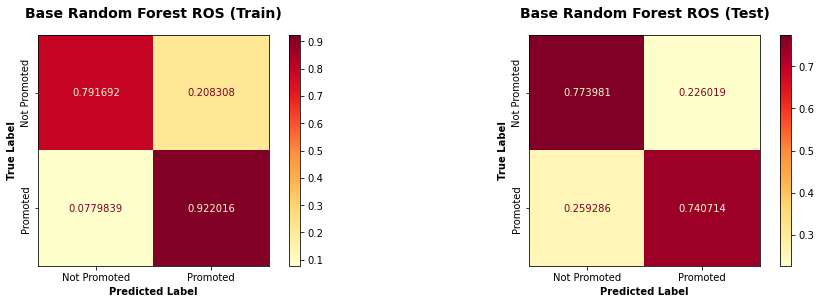


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Base Random Forest ROS,0.922016,0.740714


In [1184]:
# Using oversampled data
name = input()
RanFor = RandomForestClassifier().fit(X_train_ROS, y_train_ROS)
RF_OStrainPred = RanFor.predict(X_train_ROS)
RF_OStestPred = RanFor.predict(X_test)

recallScore = pd.DataFrame({
    "Positive Train Recall Score" : recall_score(y_train_ROS, RF_OStrainPred),
    "Positive Test Recall Score" : recall_score(y_test, RF_OStestPred)
}, index = [name])

plotConMat(name, RanFor, X_train_ROS, X_test, y_train_ROS, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScore)

Base Random Forest SMOTE


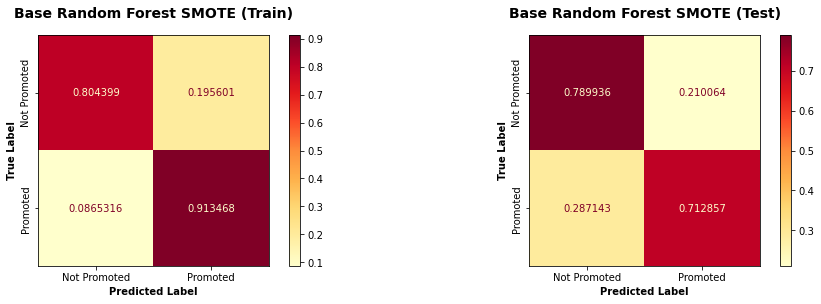


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Base Random Forest ROS,0.922016,0.740714
Base Random Forest SMOTE,0.913468,0.712857


In [1185]:
# Using SMOTE data
name = input()
RanFor = RandomForestClassifier().fit(X_train_SMOTE, y_train_SMOTE)
RF_SMOTEtrainPred = RanFor.predict(X_train_SMOTE)
RF_SMOTEtestPred = RanFor.predict(X_test)

recallScore.loc[name] = [recall_score(y_train_SMOTE, RF_SMOTEtrainPred), recall_score(y_test, RF_SMOTEtestPred)]

plotConMat(name, RanFor, X_train_SMOTE, X_test, y_train_SMOTE, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScore)

**PLEASE NOTE THAT THE CONFUSION MATRIX IS NORMALIZED TO ROW / TRUE**

ROS method provides better score, where both train and test data are higher than SMOTE's.

**In this context, our main goal is to reduce FN error rate as much as we can. If the machine suggests HR team to not promote a decent employee (FN), then there's 3 possible scenarios that could happen:**
- Loss of talent opportunity. Management fails to find someone that they could rely on bigger responsibility and workload.
- As a result, work performance and motivation of the decent employee decreases (refer to **business problem section**).
- Drops of monthly (or weekly) workload that the decent employee could handle and also the work results could lead to loss of profit. As stated before, this company is most likely a client-based company. Imagine if decent employee(s) aren't motivated anymore because of not getting promoted for certain time, then reports or projects that they supposed to handle will neglected. Deadline wouldn't be met, clients trust and satisfaction will decrease, and in the end they lower the number of requests (lower income for the company).
- At the worst case, this unfair decision could alter a good into toxic working environment because of the employee's behaviour (spreading hate speech and complaint to his fellow workers), especially if he knew his skill and work quality is definitely higher and better than the incapable promoted employee. This is of course not good for the management.

**On the other hand, company would lose nothing if the machine suggests HR team to promote an inappropriate employee (FP).** The inappropriate employee sure can learn and develop along the given time. He can increase his practical and non practical skill slowly. Haryono (2013) and other reasearcher in it also say so, where promoted employee (either he is decent or not) will gain more work motivation and satisfaction. In reality, this imbalanced idealism is rarely affect work results. Even if the boss / leader is not capable of his new responsibility, they usually and most likely will hand over the work to the subordinates. Therefore, work results is still determined by the quality of his subordinates.

Hence, we will only focus to **positive recall score**

### Logistic Regression

Base Logistic Regression ROS


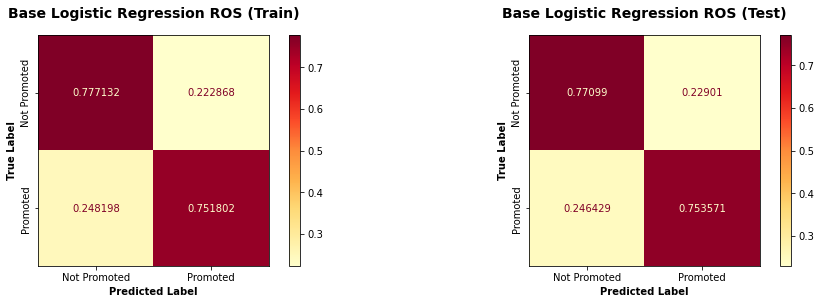


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Base Random Forest ROS,0.922016,0.740714
Base Random Forest SMOTE,0.913468,0.712857
Base Logistic Regression ROS,0.751802,0.753571


In [1186]:
# Using oversampled data
name = input()
LogReg = LogisticRegression().fit(X_train_ROS, y_train_ROS)
LG_ROStrainPred = LogReg.predict(X_train_ROS)
LG_ROStestPred = LogReg.predict(X_test)

recallScore.loc[name] = [recall_score(y_train_ROS, LG_ROStrainPred), recall_score(y_test, LG_ROStestPred)]

plotConMat(name, LogReg, X_train_ROS, X_test, y_train_ROS, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScore)

Base Logistic Regression SMOTE


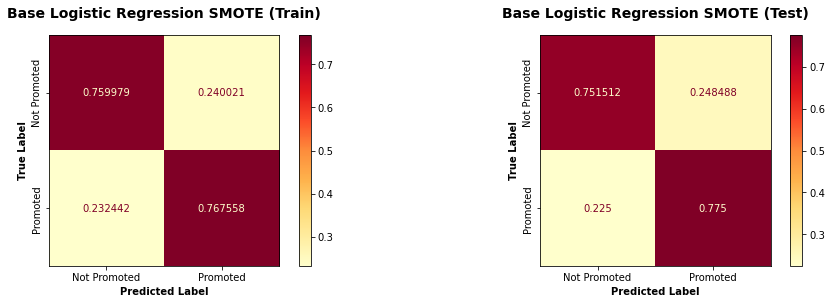


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Base Random Forest ROS,0.922016,0.740714
Base Random Forest SMOTE,0.913468,0.712857
Base Logistic Regression ROS,0.751802,0.753571
Base Logistic Regression SMOTE,0.767558,0.775000


In [1187]:
# Using SMOTE data
name = input()
LogReg = LogisticRegression().fit(X_train_SMOTE, y_train_SMOTE)
LG_SMOTEtrainPred = LogReg.predict(X_train_SMOTE)
LG_SMOTEtestPred = LogReg.predict(X_test)

recallScore.loc[name] = [recall_score(y_train_SMOTE, LG_SMOTEtrainPred), recall_score(y_test, LG_SMOTEtestPred)]

plotConMat(name, LogReg, X_train_SMOTE, X_test, y_train_SMOTE, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScore)

Meanwhile, SMOTE performs better in Logistic Regression.

### XGB Classifier

Base XGBoost ROS


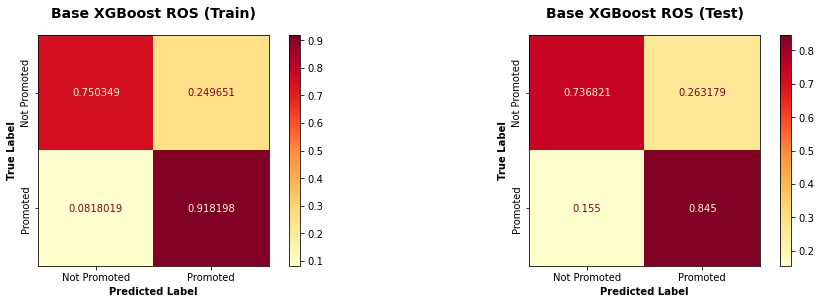


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Base Random Forest ROS,0.922016,0.740714
Base Random Forest SMOTE,0.913468,0.712857
Base Logistic Regression ROS,0.751802,0.753571
Base Logistic Regression SMOTE,0.767558,0.775000
Base XGBoost ROS,0.918198,0.845000


In [1188]:
# Using oversampled data
name = input()
XGB = XGBClassifier().fit(X_train_ROS, y_train_ROS)
XGB_ROStrainPred = XGB.predict(X_train_ROS)
XGB_ROStestPred = XGB.predict(X_test)

recallScore.loc[name] = [recall_score(y_train_ROS, XGB_ROStrainPred), recall_score(y_test, XGB_ROStestPred)]

plotConMat(name, XGB, X_train_ROS, X_test, y_train_ROS, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScore)

Base XGBoost SMOTE


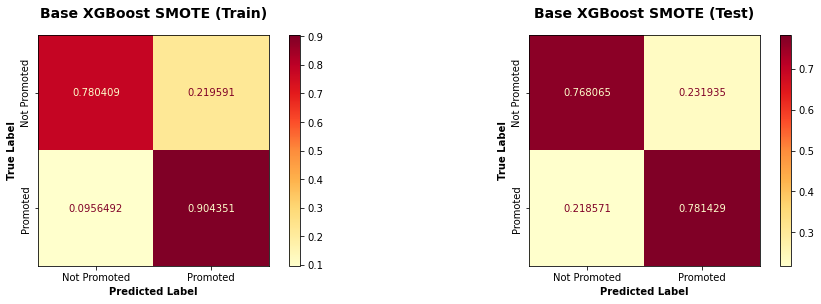


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Base Random Forest ROS,0.922016,0.740714
Base Random Forest SMOTE,0.913468,0.712857
Base Logistic Regression ROS,0.751802,0.753571
Base Logistic Regression SMOTE,0.767558,0.775000
Base XGBoost ROS,0.918198,0.845000
Base XGBoost SMOTE,0.904351,0.781429


In [1189]:
# Using SMOTE data
name = input()
XGB = XGBClassifier().fit(X_train_SMOTE, y_train_SMOTE)
XGB_SMOTEtrainPred = XGB.predict(X_train_SMOTE)
XGB_SMOTEtestPred = XGB.predict(X_test)

recallScore.loc[name] = [recall_score(y_train_SMOTE, XGB_SMOTEtrainPred), recall_score(y_test, XGB_SMOTEtestPred)]

plotConMat(name, XGB, X_train_SMOTE, X_test, y_train_SMOTE, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScore)

XGB with ROS approach is the best base model so far. It has the highest recall score and thus the lower FN rate, **only less than 2% error in predicting decent employees to be promoted**.

## Tuned Model
We will maximize each three models and seek out for the winner. But, before we jump in to tuning and hyper parameter tuning, we will start this section by applying weight parameter as the last imbalanced data approach.

### Random Forest Classifier

**Class weight**

Weighted Random Forest


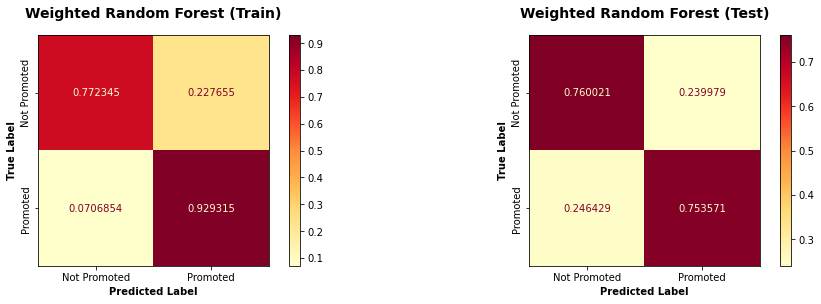


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Weighted Random Forest,0.929315,0.753571


In [1250]:
# Using class_weight parameter
name = input()
RanFor = RandomForestClassifier(class_weight = {0 : .05, 1 : .95}, random_state = 7).fit(X_train, y_train)
RF_wtrainPred = RanFor.predict(X_train)
RF_wtestPred = RanFor.predict(X_test)

recallScoreTuned = pd.DataFrame({
    "Positive Train Recall Score" : recall_score(y_train, RF_wtrainPred),
    "Positive Test Recall Score" : recall_score(y_test, RF_wtestPred)
}, index = [name])

plotConMat(name, RanFor, X_train, X_test, y_train, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScoreTuned)

Since we want to jusf focus on FN, the best class weight is as low as possible for negative class. The best value we can got is **0.5 for not promoted and 0.95 for promoted class**. Frankly, this not the highest score for both train and test because it's still possible to lower negative class weight even more. But, the consequences is recall train score would be very **near to 1 or strong learner**. This weighted train score actually is a strong learner too, but at least not as high as if we lower the weight further. 

This approach is way better than ROS and thus we'll stick to it. Even though we still got an overfit, we could reduce the score difference in hyper parameter tuning.  

**Hyper parameter tuning**

In [1253]:
# RandomizedSearchCV
RanForTuned = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions = {
        "n_estimators" : [100, 120, 150, 200, 250, 280, 300],
        "max_depth" : [None, 2, 3, 4, 5, 8, 10],
        "min_samples_split" : [2, 10, 20, 30, 40, 50],
        "min_samples_leaf" : [2, 4, 8, 14, 17, 22, 29, 30],
        "max_features" : ["auto", .2, .5],
        "min_impurity_decrease" : [0, 0.2, 0.3, 0.5],
        "class_weight" : [{0 : .05, 1 : .95}],
        "random_state" : [7]
        }, cv = 3, n_jobs = -1, verbose = 1, n_iter = 40
    )

RanForTuned.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=40,
                   n_jobs=-1,
                   param_distributions={'class_weight': [{0: 0.05, 1: 0.95}],
                                        'max_depth': [None, 2, 3, 4, 5, 8, 10],
                                        'max_features': ['auto', 0.2, 0.5],
                                        'min_impurity_decrease': [0, 0.2, 0.3,
                                                                  0.5],
                                        'min_samples_leaf': [2, 4, 8, 14, 17,
                                                             22, 29, 30],
                                        'min_samples_split': [2, 10, 20, 30, 40,
                                                              50],
                                        'n_estimators': [100, 120, 150, 200,
                                                         250, 280, 300],
                                        'random_state': [7]},
 

Tuned Random Forest


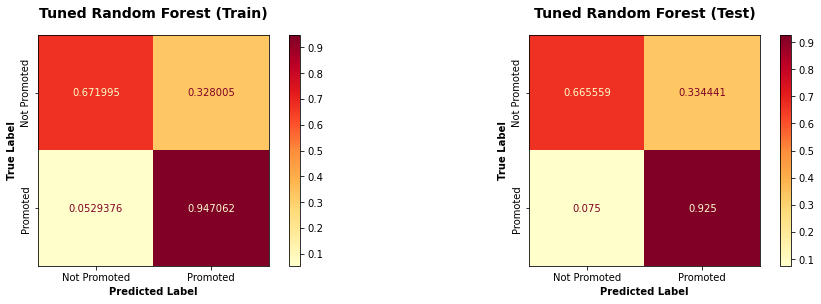


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Weighted Random Forest,0.929315,0.753571
Tuned Random Forest,0.947062,0.925000


In [1254]:
# Tuned model
name = input()
bestRanForTuned = RanForTuned.best_estimator_
RF_tunedtrainPred = bestRanForTuned.predict(X_train)
RF_tunedtestPred = bestRanForTuned.predict(X_test)

recallScoreTuned.loc[name] = [recall_score(y_train, RF_tunedtrainPred), recall_score(y_test, RF_tunedtestPred)]

plotConMat(name, bestRanForTuned, X_train, X_test, y_train, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScoreTuned)

The tuned model gains high increment in test score, meanwhile just a slight score in train. This is absolutely good for us since the model decereases gap in train and data score, hence it becomes more perfectly-fit. Besides, increment in train score still doesn't make this model too strong learner (memorize, not learning pattern).

### Logistic Regression

**Class weight**

Weighted Logistic Regression


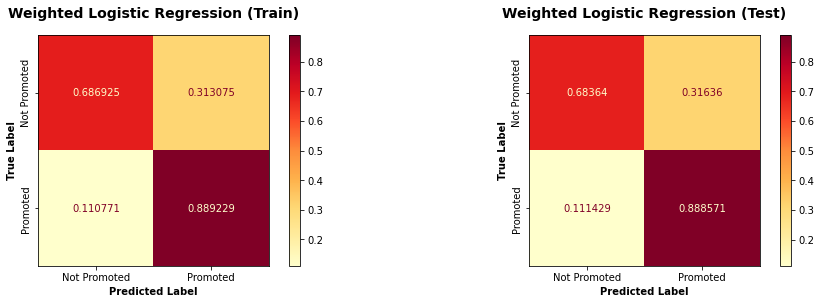


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Weighted Random Forest,0.929315,0.753571
Tuned Random Forest,0.947062,0.925000
Weighted Logistic Regression,0.889229,0.888571


In [1255]:
# Using class_weight parameter
name = input()
LogReg = LogisticRegression(class_weight = {0 : .05, 1 : .95}, random_state = 7).fit(X_train, y_train)
LG_wtrainPred = LogReg.predict(X_train)
LG_wtestPred = LogReg.predict(X_test)

recallScoreTuned.loc[name] = [recall_score(y_train, LG_wtrainPred), recall_score(y_test, LG_wtestPred)]

plotConMat(name, LogReg, X_train, X_test, y_train, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScoreTuned)

Again, the best weight is 0.5 and 0.95 for the classes just like Random Forest. The difference is, Logistic Regression succeed to equalize the train and test score **perfectly**. So, we got a non hypertuned model with good score and perfectly fit. However, we still want to maximize it and try if it could increase by a slight number. Hence, we will use this class weight to perform hyper parameter tuning.

We will apply scaling method to enhance model performance and fulfill **penalty terms**, where all features must be scaled first so there would be no bias.

In [1315]:
# Scaling
XS_train = MinMaxScaler().fit_transform(X_train)
XS_test = MinMaxScaler().fit_transform(X_test)

**Hyper parameter tuning**

In [1318]:
# RandomizedSearchCV
LogRegTuned = RandomizedSearchCV(
    estimator = LogisticRegression(),
    param_distributions = {
        "penalty" : ["l1", "l2", "elasticnet"],
        "max_iter" : [100, 300, 500, 600, 250, 400, 550, 150],
        "C" : [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
        "class_weight" : [{0 : .05, 1 : .95}],
        "random_state" : [7]
        }, cv = 4, n_jobs = -1, verbose = 1, n_iter = 30
    )

LogRegTuned.fit(XS_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.8s finished


RandomizedSearchCV(cv=4, estimator=LogisticRegression(), n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                              0.6, 0.7, 0.8],
                                        'class_weight': [{0: 0.05, 1: 0.95}],
                                        'max_iter': [100, 300, 500, 600, 250,
                                                     400, 550, 150],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'random_state': [7],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   verbose=1)

Tuned Logistic Regression


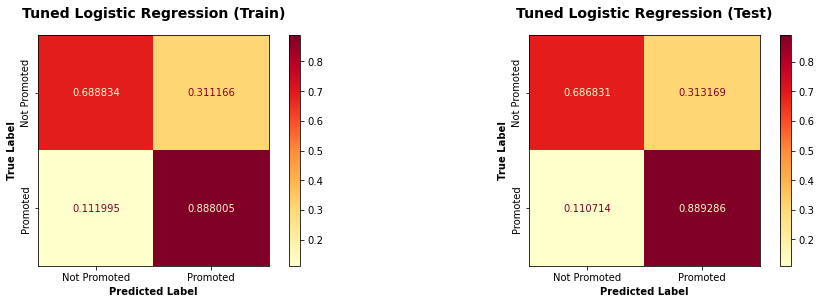


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Weighted Random Forest,0.929315,0.753571
Tuned Random Forest,0.947062,0.925000
Weighted Logistic Regression,0.889229,0.888571
Tuned Logistic Regression,0.888005,0.889286


In [1319]:
# Tuned model
name = input()
bestLogRegTuned = LogRegTuned.best_estimator_
LG_tunedtrainPred = bestLogRegTuned.predict(XS_train)
LG_tunedtestPred = bestLogRegTuned.predict(XS_test)

recallScoreTuned.loc[name] = [recall_score(y_train, LG_tunedtrainPred), recall_score(y_test, LG_tunedtestPred)]

plotConMat(name, bestLogRegTuned, XS_train, XS_test, y_train, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScoreTuned)

Test score performs better than train score and also increases slightly from the weighted only model.

### XGB Classifier

Just like the other two, we can alter weight proportion between minority and majority class in XGB using **scale_pos_weight**. The normative and common formula for this parameter is **total negative targets / total positive target**.

**Weight ratio**

Weighted XGBoost


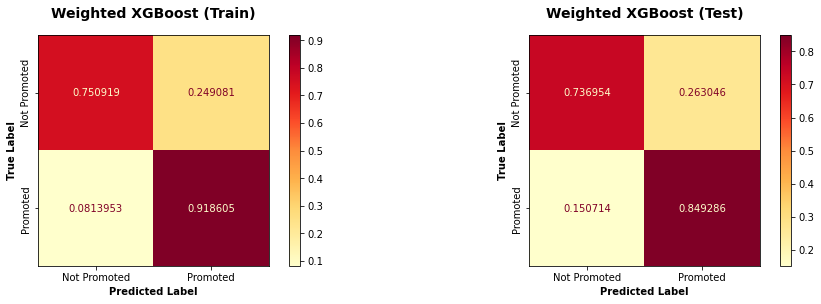


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Weighted Random Forest,0.929315,0.753571
Tuned Random Forest,0.947062,0.925000
Weighted Logistic Regression,0.889229,0.888571
Tuned Logistic Regression,0.888005,0.889286
Weighted XGBoost,0.918605,0.849286


In [1320]:
# Using scale_pos_weight parameter
name = input()
XGB = XGBClassifier(scale_pos_weight = len(y[y == 0]) / len(y[y == 1]), random_state = 7).fit(X_train, y_train)
XGB_wtrainPred = XGB.predict(X_train)
XGB_wtestPred = XGB.predict(X_test)

recallScoreTuned.loc[name] = [recall_score(y_train, XGB_wtrainPred), recall_score(y_test, XGB_wtestPred)]

plotConMat(name, XGB, X_train, X_test, y_train, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScoreTuned)

Weighted class approach give us a **very slight difference** than ROS, where train and test are 0.918198 and 0.845000 respectively. However, we still wanna use the highest one, so we will use this weight ratio.

**Hyper parameter tuning**

In [1327]:
# RandomizedSearchCV
XGBTuned = RandomizedSearchCV(
    estimator = XGBClassifier(),
    param_distributions = {
        "booster" : ["gbtree", "gblinear", "dart"],
        "max_depth" :  [d for d in range(3, 9)],
        "learning_rate" : [l for l in np.arange(0.02, 0.08, 0.01)],
        "n_estimators" : [100, 120, 150, 170, 200, 220, 250],
        "gamma" : [0, 1, 5],
        "colsample_bytree" : [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        "random_state" : [7],
        "scale_pos_weight" : [len(y[y == 0]) / len(y[y == 1])]
    }, cv = 4, n_jobs = -1, verbose = 1, n_iter = 30
    )

XGBTuned.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 17.7min finished


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'colsa

Tuned XGBoost


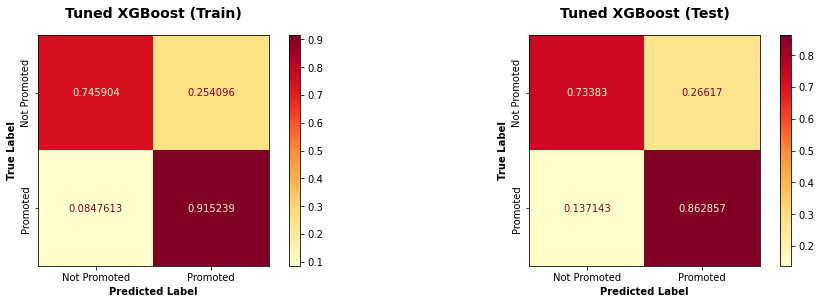


Positive Recall Score Train vs Test :


,Positive Train Recall Score,Positive Test Recall Score
Weighted Random Forest,0.929315,0.753571
Tuned Random Forest,0.947062,0.925000
Weighted Logistic Regression,0.889229,0.888571
Tuned Logistic Regression,0.888005,0.889286
Weighted XGBoost,0.918605,0.849286
Tuned XGBoost,0.915239,0.862857


In [1328]:
# Tuned model
name = input()
bestXGBTuned = XGBTuned.best_estimator_
XGB_tunedtrainPred = bestXGBTuned.predict(X_train)
XGB_tunedtestPred = bestXGBTuned.predict(X_test)

recallScoreTuned.loc[name] = [recall_score(y_train, XGB_tunedtrainPred), recall_score(y_test, XGB_tunedtestPred)]

plotConMat(name, bestXGBTuned, X_train, X_test, y_train, y_test)

print("\nPositive Recall Score Train vs Test :")
display(recallScoreTuned)

**ROC Curve**

After all attempts, we found that tuned Random Forest is the best model for us **because it provides the least FN rate**. In this case, we really don't care about how many FP occurs in the prediction. If only we pick the **best balanced model**, we should pick tuned XGB over the others. XGB has the highest AUC score because besides attempting to reduce FN, it also simultaneously reduce FP score. Thus, it has the lowest FP score across the model and as a result has the **widest** AUC area.

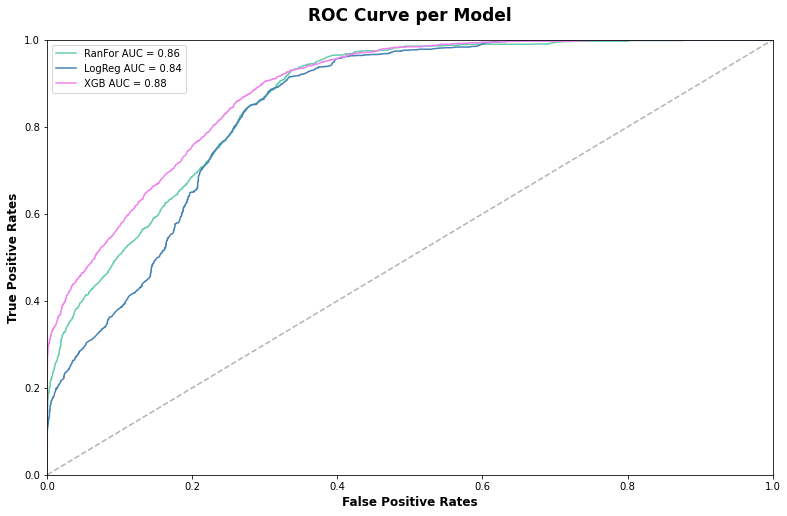

In [1335]:
# FPR and TPR per model
RF_fpr, RF_tpr, RF_th = roc_curve(y_test, RF_tunedtestProbs)
LG_fpr, LG_tpr, LG_th = roc_curve(y_test, LG_tunedtestProbs)
XGB_fpr, XGB_tpr, XGB_th = roc_curve(y_test, XGB_tunedtestProbs)

# Plotting
plt.figure(figsize = (13, 8))
plt.plot(RF_fpr, RF_tpr, color = "mediumaquamarine", label = f"RanFor AUC = {round(auc(RF_fpr, RF_tpr), 2)}")
plt.plot(LG_fpr, LG_tpr, color = "steelblue", label = f"LogReg AUC = {round(auc(LG_fpr, LG_tpr), 2)}")
plt.plot(XGB_fpr, XGB_tpr, color = "violet", label = f"XGB AUC = {round(auc(XGB_fpr, XGB_tpr), 2)}")
plt.plot([0, 1], [0, 1], color = "grey", alpha = 0.6, ls = "--")
plt.title(
        "ROC Curve per Model", fontdict = {'fontsize': 17,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03
    )
plt.xlabel(
    "False Positive Rates",
    fontdict = {
        "weight" : "bold",
        "size" : 12
    }
    )
plt.ylabel(
    "True Positive Rates",
    fontdict = {
        "weight" : "bold",
        "size" : 12
    }
    )
plt.xlim([0 , 1])
plt.ylim([0 , 1])
plt.legend()

plt.show()

In [1336]:
# Exporting tuned Random Forest
joblib.dump(bestRanForTuned, "./bestModel")

['./bestModel']

# Recommendation

- The tuned Random Forest is good enough yet still can be maximized. There's plenty of rooms for improvement, especially on bagging the train score even more. It is believed the tuned model could be more perfectly-fit than it is. 
- It is suggested to enhance the tuned Logistic Regression because it seems to have potential to exceed Random Forest. Not only on the score itself, but also on the balance of train and test score, which Logistic Regression is better at. The best way to improve it is finding the best class weight.
- This model is most likely can't be implemented on small, new, or unsettled companies. Most of the time, they don't have a rigid regulations and assessment yet for the employees. These type of company tend to use informal and situational approach to do job promotion. Meanwhile, this model is suitable for big and settled company, which already have a mature system and regulation.